##############################################################################################################################

# Table of content

## <a href='#problematic'>Problematic</a>
## <a href='#librairies'>Import librairies</a>
## <a href='#load_data'>Load the dataset</a>
## <a href='#explo'>Exploring & Cleaning</a>
## <a href='#features_creation'>Features creation</a>
### <a href='#emails_containing_URL'>_Emails containing URL links</a>
### <a href='#emails_containing_object'>_Emails containing attachment object</a>
### <a href='#emails_words_count'>_Emails words count</a>
### <a href='#emails_words_corrected_count'>_Emails words corrected count</a>
### <a href='#TF_IDF'> _TF-IDF vectorization to convert 'Email Text' into numerical feature</a>
## <a href='#classification_models'> Classification models</a>
### <a href='#classification_models_1'>1_Logistic Regression</a>
### <a href='#MultinomialNB_2'>2_Naives Bayes</a>
## <a href='#best_model'>Loading the scaler and the best model</a>

##############################################################################################################################

# Problematic <a id='problematic'></a>

In today's digital landscape, phishing emails have become the primary vector through which hackers reach their victims and illicitly obtain and sell their personal data.

What is a phishing email?
Phishing is a cyber attack where hackers impersonate trusted entities to trick the users and steal their personnal data.

Recognizing the severity of this issue, our objective is to enhance user protection by developing an effective detection system for phishing emails. 

In this section, we will explore the implementation of different machine learning models as part of our classification analysis: 
- Logistic Regression,
- Naives Bayes.

Our aim is to identify the best model with the highest score to accurately predict whether an email is a phishing attempt or not.

# Import librairies <a id='librairies'></a>

In [1]:
import pandas as pd
import numpy as np
import re
import cleaning_functions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from collections import Counter
from symspellpy import SymSpell, Verbosity
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup

# Load the dataset <a id='load_data'></a>

In [2]:
df = pd.read_csv('../data/cleaned/dataset_phishing.csv', encoding='ISO-8859-1')
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


# Exploring & Cleaning <a id='explo_cleaning'></a>

In [4]:
#check of the rows and columns number
df.shape

(18650, 2)

In [5]:
#check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  18634 non-null  object
 1   Email Type  18650 non-null  object
dtypes: object(2)
memory usage: 291.5+ KB


In [6]:
#overview of the dataset
df.describe().T

,count,unique,top,freq
Email Text,18634,17537,empty,533
Email Type,18650,2,Safe Email,11322


In [7]:
#check of the dupplicates percentage 
total_rows = df.shape[0]
duplicate_percentage = (df.duplicated().sum() / total_rows) * 100

print(f"Percentage of duplicate rows: {duplicate_percentage:.2f}%")

Percentage of duplicate rows: 5.96%


In [8]:
#the percentage of dupplicates is low, let's drop it
df.drop_duplicates(inplace=True)

In [9]:
#check of the missing valus in 'Safe Email' type
df_safe_email = df[df['Email Type'] == "Safe Email"]
df_safe_email

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
...,...,...
18642,URL: http://diveintomark.org/archives/2002/09/...,Safe Email
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,Safe Email
18646,request submitted : access request for anita ....,Safe Email
18647,"re : important - prc mtg hi dorn & john , as y...",Safe Email


In [10]:
df_safe_email.isna().sum()

Email Text    0
Email Type    0
dtype: int64

In [11]:
#check of the missing valus in 'Phishing Email' type
df_phishing_email = df[df['Email Type'] == "Phishing Email"]
df_phishing_email

,Email Text,Email Type
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
10,make her beg you to give it to her everynight ...,Phishing Email
...,...,...
18623,picks from analyst with high - level precision...,Phishing Email
18627,"crying mlcros 0 ft , symanntec , macromedia , ...",Phishing Email
18634,congratulations you have won ! ! ! pls contact...,Phishing Email
18638,strong buy alert : monthly newsletter topstock...,Phishing Email


In [12]:
df_phishing_email.isna().sum()

Email Text    1
Email Type    0
dtype: int64

In [13]:
#the volume of nan is low, let's drop it
df.dropna(inplace=True)

In [14]:
#check the update of missing values in the whole dataset
df.isnull().sum() / len(df) *100

Email Text    0.0
Email Type    0.0
dtype: float64

In [15]:
#check of the volume of 'Email Type'
email_type_counts = df['Email Type'].value_counts(normalize=True)
email_type_percentages = email_type_counts * 100
email_type_percentages

Email Type
Safe Email        62.606911
Phishing Email    37.393089
Name: proportion, dtype: float64

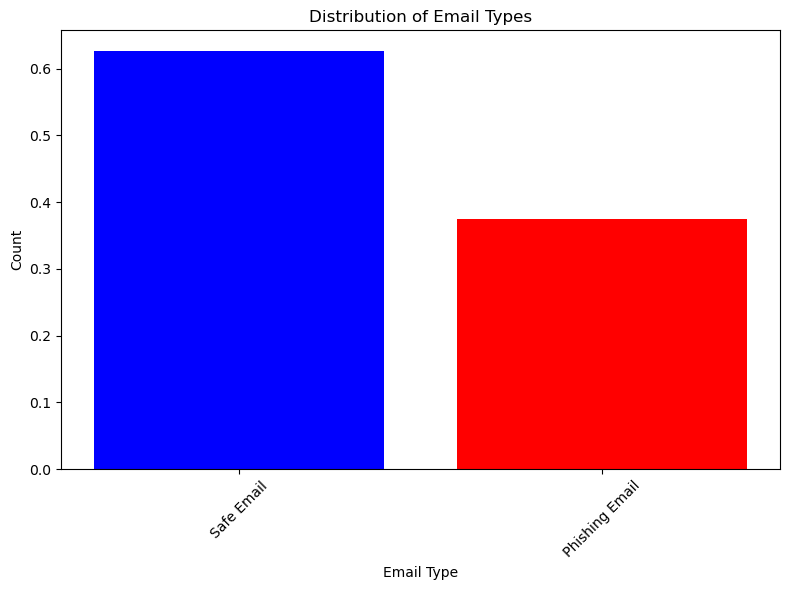

In [16]:
#Distribution of Email Types
unique_email_types = email_type_counts.index.tolist()
color_map = {
    'Phishing Email': 'red',
    'Safe Email': 'blue',}
colors = [color_map.get(email_type, 'gray') for email_type in unique_email_types]

# Create the bar chart with custom colors
plt.figure(figsize=(8, 6))
plt.bar(unique_email_types, email_type_counts, color=colors)
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Email Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

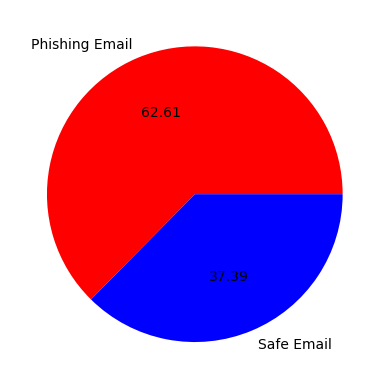

In [17]:
#Pie of Email Types
#there is more 'Phishing Email' type in the dataset than 'Safe'
#Let's fix this class imbalance issue later
email_type_counts = df['Email Type'].value_counts()
colors = ['#FF0000', '#0000FF']

plt.pie(email_type_counts, labels=['Phishing Email', 'Safe Email'], autopct='%0.2f', colors=colors)
plt.show()

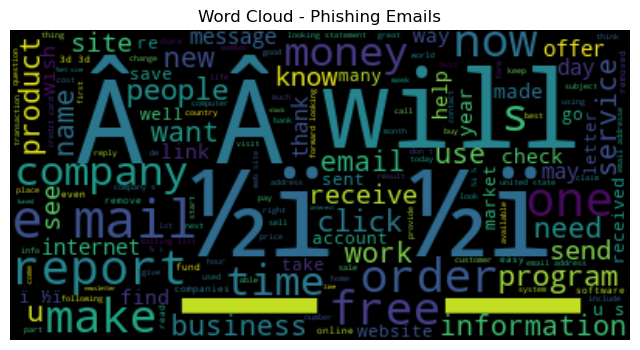

In [18]:
#Vizualisation of the frequent words in 'Phishing Email' type
#required libraries
#!pip install wordcloud

#filter the df for phishing emails
phishing_emails = df[df['Email Type'] == 'Phishing Email']

#WordCloud for phishing emails
phishing_wordcloud = WordCloud().generate(' '.join(phishing_emails['Email Text']))

#figure and axis for the phishing word cloud
plt.figure(figsize=(8, 8))
plt.imshow(phishing_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Phishing Emails')
plt.axis('off')
plt.show()

#We observe more special characters, the 'urgency' ton, 'money', 'click'

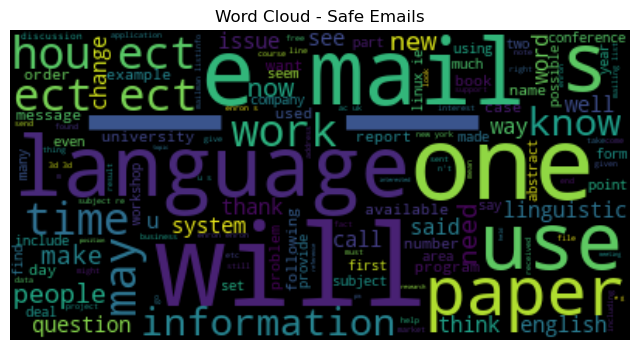

In [19]:
#filter the dataframe for safe emails
safe_emails = df[df['Email Type'] == 'Safe Email']

#WordCloud for safe emails
safe_wordcloud = WordCloud().generate(' '.join(safe_emails['Email Text']))

#figure and axis for the safe word cloud
plt.figure(figsize=(8, 8))
plt.imshow(safe_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Safe Emails')
plt.axis('off')
plt.show()

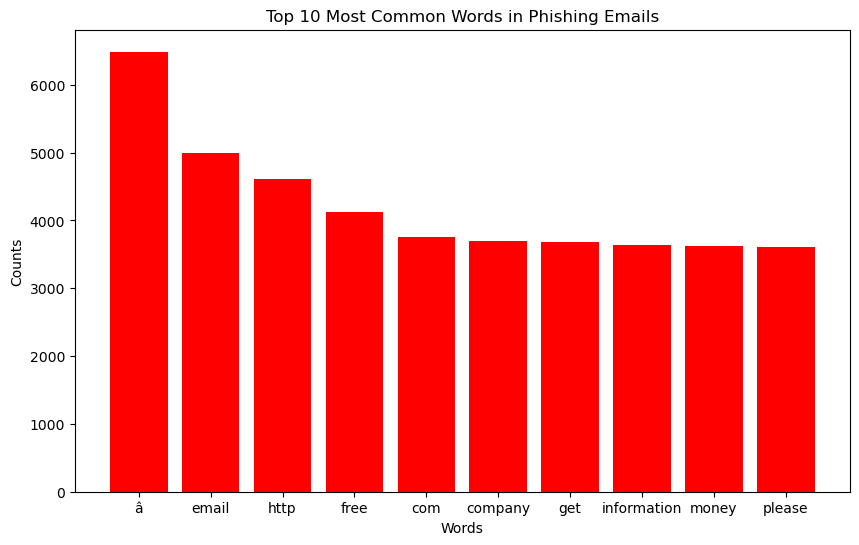

In [20]:
# Data visualization - Top 10 Most Common Words in Phishing Emails
# Filter the dataframe for phishing emails
phishing_emails = df[df['Email Type'] == 'Phishing Email']

# Concatenate the text from all the phishing emails
phishing_text = ' '.join(phishing_emails['Email Text'])

# Tokenize the text into individual words
phishing_tokens = word_tokenize(phishing_text)

# Remove stopwords and lowercase the tokens
stopwords_set = set(stopwords.words('english'))
phishing_words = [word.lower() for word in phishing_tokens if word.lower() not in stopwords_set and word.isalpha()]

# Count the frequency of each word
phishing_word_counts = Counter(phishing_words)

# Find the top 10 most common words in phishing emails
phishing_top_words = phishing_word_counts.most_common(10)

# Extract word and count into separate lists
phishing_words, phishing_counts = zip(*phishing_top_words)

# Set the color for the phishing bars
phishing_color = 'red'

# Create a bar plot for the top 10 most common words in phishing emails with red color
plt.figure(figsize=(10, 6))
plt.bar(phishing_words, phishing_counts, color=phishing_color)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 10 Most Common Words in Phishing Emails')
plt.show()

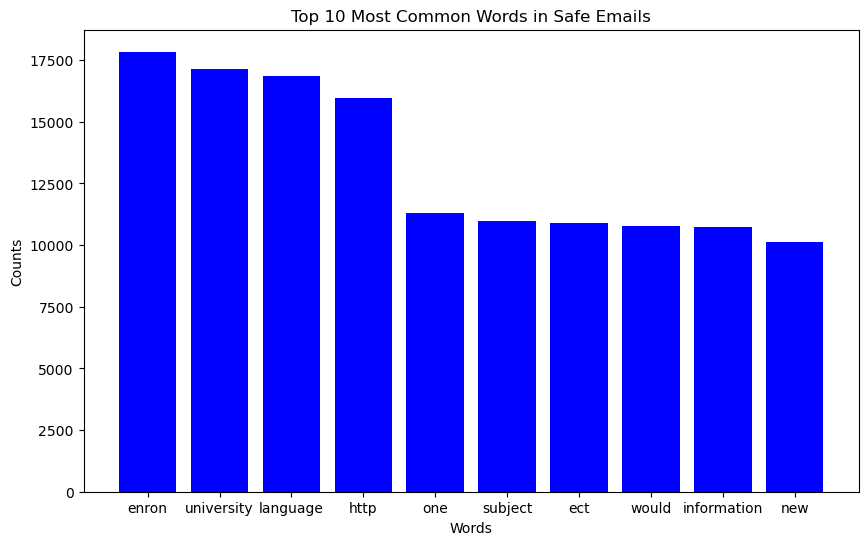

In [21]:
# Data visualization - Top 10 Most Common Words in Safe Emails
# Filter the dataframe for safe emails
safe_emails = df[df['Email Type'] == 'Safe Email']

# Concatenate the text from all the safe emails
safe_text = ' '.join(safe_emails['Email Text'])

# Tokenize the text into individual words
safe_tokens = word_tokenize(safe_text)

# Remove stopwords and lowercase the tokens
safe_words = [word.lower() for word in safe_tokens if word.lower() not in stopwords_set and word.isalpha()]

# Count the frequency of each word
safe_word_counts = Counter(safe_words)

# Find the top 10 most common words in safe emails
safe_top_words = safe_word_counts.most_common(10)

# Extract word and count into separate lists
safe_words, safe_counts = zip(*safe_top_words)

# Set the color for the safe bars
safe_color = 'blue'

# Create a bar plot for the top 10 most common words in safe emails with blue color
plt.figure(figsize=(10, 6))
plt.bar(safe_words, safe_counts, color=safe_color)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 10 Most Common Words in Safe Emails')
plt.show()

In [22]:
#label the 'Email Type' column and add 0 for 'Safe Email' and 1 for'Phishing Email'
df['email_type'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})
df.head()

,Email Text,Email Type,email_type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,Safe Email,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1


# Features creation <a id='features_creation'></a>

In [23]:
df.head(5)

,Email Text,Email Type,email_type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,Safe Email,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1


In [24]:
#check of the first five 'Email Text' in order to create more features
for index, description in enumerate(df['Email Text'].iloc[0:5],start=1):
    print(f"{index}: {description} \n")


1: re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not co

## _Emails containing URL links <a id='emails_containing_URL'></a>

In [25]:
#function to include the emails containing URL links
#there is often a  malicious link in phishing emails

def contains_url(text):
    text_str = str(text)
    pattern = r'http?://\S+'
    if re.search(pattern, text_str):
        return 1
    else: 
        return 0

df.loc[:, 'including_url'] = df['Email Text'].apply(contains_url)
df.head()

,Email Text,Email Type,email_type,including_url
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0,0
2,re : equistar deal tickets are you still avail...,Safe Email,0,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,0


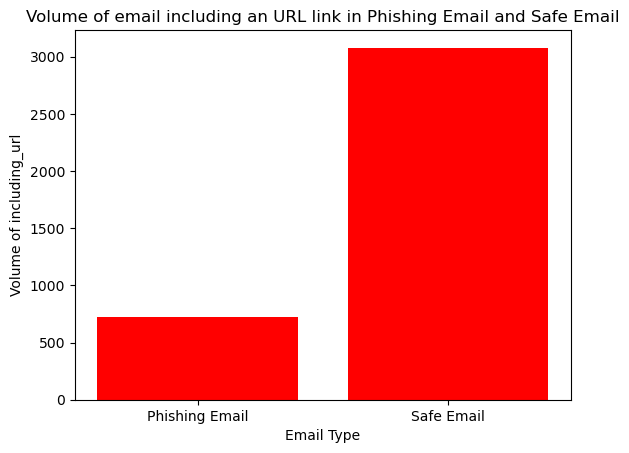

In [26]:
#this feature is finally not representative of our intuition 
#Filter the DataFrame for 'Phishing Email' and 'Safe Email'
phishing_df = df[df['Email Type'] == 'Phishing Email']
safe_email_df = df[df['Email Type'] == 'Safe Email']

# Calculate the volume of including_url for 'Phishing Email'
phishing_including_url_volume = phishing_df['including_url'].sum()

# Calculate the volume of including_url for 'Safe Email'
safe_email_including_url_volume = safe_email_df['including_url'].sum()

# Create a bar plot
plt.bar(['Phishing Email', 'Safe Email'], [phishing_including_url_volume, safe_email_including_url_volume], color='red')
plt.xlabel('Email Type')
plt.ylabel('Volume of including_url')
plt.title('Volume of email including an URL link in Phishing Email and Safe Email')
plt.show()

## _Emails containing attachment object<a id='emails_containing_object'></a>

In [27]:
#function to check if there is an attachment object in the text
#this feature is finally not representative of our intuition labels = ['Phishing Email', 'Safe Email']
def check_attachment(text):
    if 'attachment' in text.lower():
        return 1
    else:
        return 0

# Add a new column indicating the presence of an attachment
df['attachment_object'] = df['Email Text'].apply(check_attachment)

df.head()

,Email Text,Email Type,email_type,including_url,attachment_object
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,0,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0,0,0
2,re : equistar deal tickets are you still avail...,Safe Email,0,0,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1,1,0
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,0,0


In [28]:
#check the number of attachment
attachment_counts = df['attachment_object'].value_counts()

# Display the counts
print(attachment_counts)

attachment_object
0    17341
1      197
Name: count, dtype: int64


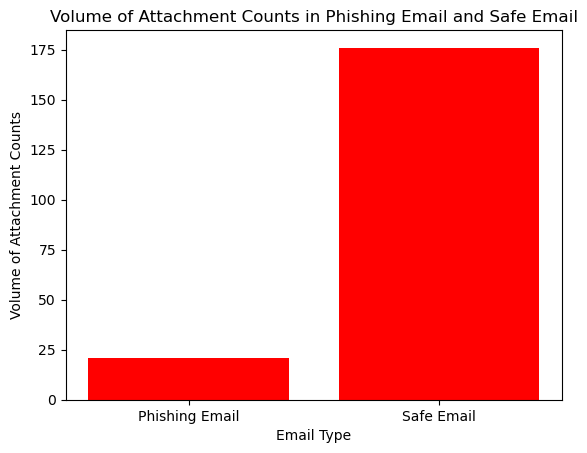

In [29]:
#this feature is finally not representative of our intuition 
# Calculate the volume of attachment_counts for 'Phishing Email'
phishing_attachment_volume = df[df['Email Type'] == 'Phishing Email']['attachment_object'].sum()

# Calculate the volume of attachment_counts for 'Safe Email'
safe_email_attachment_volume = df[df['Email Type'] == 'Safe Email']['attachment_object'].sum()


# Create a bar plot
plt.bar(['Phishing Email', 'Safe Email'], [phishing_attachment_volume, safe_email_attachment_volume], color='red')
plt.xlabel('Email Type')
plt.ylabel('Volume of Attachment Counts')
plt.title('Volume of Attachment Counts in Phishing Email and Safe Email')
plt.show()

## _Emails words count<a id='emails_words_count'></a>

In [30]:
#count the number of words in 'Email Text'
df['word_count'] = df['Email Text'].apply(lambda x: len(x.split()))

df.head()

,Email Text,Email Type,email_type,including_url,attachment_object,word_count
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,0,0,230
1,the other side of * galicismos * * galicismo *...,Safe Email,0,0,0,91
2,re : equistar deal tickets are you still avail...,Safe Email,0,0,0,305
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1,1,0,96
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,0,0,91


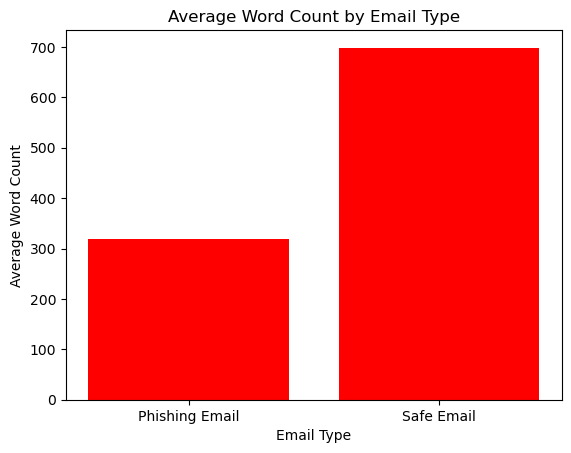

In [31]:
# Calculate the average word_count by Email Type
avg_word_count = df.groupby('Email Type')['word_count'].mean()

# Create a bar plot
plt.bar(avg_word_count.index, avg_word_count.values, color='red')
plt.xlabel('Email Type')
plt.ylabel('Average Word Count')
plt.title('Average Word Count by Email Type')
plt.show()

## _Emails words corrected count<a id='emails_words_corrected_count'></a>

In [32]:
#function to count the words corrected
#Correcting misspelled words in a dataset helps standardize the text, making it more uniform and easier for machine learning models. 
#However, in phishing emails, misspellings is a specific feature. 
#To balance this, we can count the number of misspelled words as a feature for phishing detection while maintaining data integrity.

def correct_and_count_misspelled_words(text, sym_spell):
    corrected_words = []
    corrections_count = 0

    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        
        if suggestions:
            corrected_word = suggestions[0].term
            if corrected_word != word:
                corrections_count += 1
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word)
            
    return corrections_count

#SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = "frequency_dictionary_en.txt" 
#downloaded from https://github.com/wolfgarbe/SymSpell/blob/master/SymSpell/frequency_dictionary_en_82_765.txt
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Apply the function to the df
df.loc[:,'corrected_word_count'] = df['Email Text'].apply(lambda x: correct_and_count_misspelled_words(x, sym_spell))

df.head()

,Email Text,Email Type,email_type,including_url,attachment_object,word_count,corrected_word_count
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,0,0,230,68
1,the other side of * galicismos * * galicismo *...,Safe Email,0,0,0,91,28
2,re : equistar deal tickets are you still avail...,Safe Email,0,0,0,305,146
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1,1,0,96,29
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,0,0,91,28


Average Corrected Word Count in Phishing Email: 113.69319914608113
Average Corrected Word Count in Safe Email: 274.2366120218579


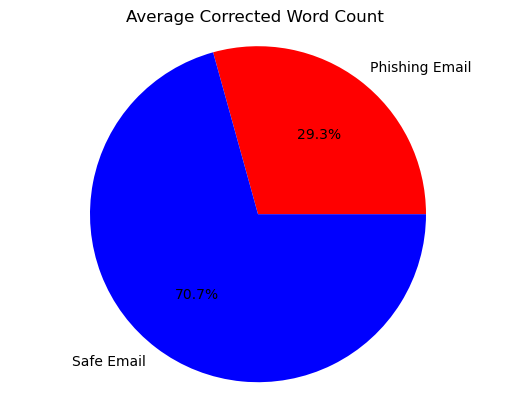

In [33]:
#check the number of corrected_word_count
#this feature is finally not representative of our intuition 

# Calculate the average corrected_word_count for dfPhishing Email'
phishing_avg_corrected_word_count = df[df['Email Type'] == 'Phishing Email']['corrected_word_count'].mean()
# Calculate the average corrected_word_count for 'Safe Email'
safe_avg_corrected_word_count = df[df['Email Type'] == 'Safe Email']['corrected_word_count'].mean()


print("Average Corrected Word Count in Phishing Email:", phishing_avg_corrected_word_count)
print("Average Corrected Word Count in Safe Email:", safe_avg_corrected_word_count)

#plot
labels = ['Phishing Email', 'Safe Email']
sizes = [phishing_avg_corrected_word_count, safe_avg_corrected_word_count]
colors = ['red', 'blue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Average Corrected Word Count ')
plt.show()

In [34]:
df.head(100)

,Email Text,Email Type,email_type,including_url,attachment_object,word_count,corrected_word_count
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,0,0,230,68
1,the other side of * galicismos * * galicismo *...,Safe Email,0,0,0,91,28
2,re : equistar deal tickets are you still avail...,Safe Email,0,0,0,305,146
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1,1,0,96,29
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,0,0,91,28
...,...,...,...,...,...,...,...
96,you ' ve been selected for the low rates progr...,Phishing Email,1,0,0,85,42
97,A:link {TEX-DECORATION: none}A:active {TEXT-DE...,Phishing Email,1,0,0,465,100
98,syntax of east asian languages workshop usc wo...,Safe Email,0,0,0,327,119
99,bulker cd ! bulker cd ! * * * * * * * * * * * ...,Phishing Email,1,0,0,634,285


In [35]:
#checking of the type of each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17538 entries, 0 to 18648
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Email Text            17538 non-null  object
 1   Email Type            17538 non-null  object
 2   email_type            17538 non-null  int64 
 3   including_url         17538 non-null  int64 
 4   attachment_object     17538 non-null  int64 
 5   word_count            17538 non-null  int64 
 6   corrected_word_count  17538 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.1+ MB


In [36]:
#check what is considered as numerical variable
numericals = df.select_dtypes(np.number)
numericals.head()

,email_type,including_url,attachment_object,word_count,corrected_word_count
0,0,0,0,230,68
1,0,0,0,91,28
2,0,0,0,305,146
3,1,1,0,96,29
4,1,0,0,91,28


In [37]:
#check what is considered as categoricals variable
categoricals = df.select_dtypes([object])
categoricals.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [38]:
#apply the necessary modifications
numericals = ['word_count', 'corrected_word_count']
for column in numericals:
    df[column] = pd.to_numeric(df[column], errors = 'coerce')

In [39]:
#apply the necessary modifications
categoricals = ['email_type', 'including_url', 'attachment_object']
for column in categoricals:
    df[column] = df[column].astype(object)

In [40]:
#rechecking the type
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17538 entries, 0 to 18648
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Email Text            17538 non-null  object
 1   Email Type            17538 non-null  object
 2   email_type            17538 non-null  object
 3   including_url         17538 non-null  object
 4   attachment_object     17538 non-null  object
 5   word_count            17538 non-null  int64 
 6   corrected_word_count  17538 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.1+ MB


## _TF-IDF vectorization to convert 'Email Text' into numerical feature <a id='TF_IDF'></a>

In [41]:
#Let's create first our "corpus" or database of "possible words" in the reviews. 
#This is a specific set of common words in the 'Email Text'

emails = ''

for email in df['Email Text'].loc[:10]: #let's take a low sample
    emails += email

corpus = nltk.sent_tokenize(emails)

In [42]:
corpus

['re : 6 .',
 '1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson \'s observations on us use of \'s on \' but not \'d aughter \' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " .',
 "for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' .",
 'for another , there seem to me to be differences here .',
 'if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e .',
 'g .',
 ", calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! '",
 "or ' son , help me ! '",
 '( although 

In [43]:
#We would like to clean the text by means of:

#*use lowercase
#*drop punctuation marks
#*removing too many consecutive white spaces
#*removing digits
#*removing email addreses
#*removing websites
#*removing html tags

In [44]:
for i in range(len(corpus)):
    corpus[i] = corpus[i].lower()
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ',corpus[i]) # Replace one or more whitespaces by  ' '
    corpus[i] = re.sub(r'\d+',' ',corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", corpus[i]) # Replace e-mails by ''
    # Replace urls by ''
    corpus[i] = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , corpus[i])
    # Replace html tags by ''
    corpus[i] = BeautifulSoup(corpus[i], 'lxml').get_text().strip()

In [45]:
corpus[:5]

['re',
 'disc uniformitarianism re   sex lang dick hudson s observations on us use of s on but not d aughter as a vocative are very thought provoking but i am not sure that it is fair to attribute this to sons being treated like senior relatives',
 'for one thing we do n t normally use brother in this way any more than we do d aughter and it is hard to imagine a natural class comprising senior relatives and s on but excluding brother',
 'for another there seem to me to be differences here',
 'if i am not imagining a distinction that is not there it seems to me that the senior relative terms are used in a wider variety of contexts e']

In [46]:
#we could think of predicting the number of stars for each email and get what is the probability of getting a given word 
#However, given limited capabilities in terms of the vocabulary, we're goign to switch to NLTK library.
tfidf = TfidfVectorizer(lowercase=True, # lowecase all the words in the corpus (default value)
                     stop_words='english',
                     ngram_range=(1,1), # min and max n-gram size
                     analyzer='word',
                     max_features=30) # Vocabulary using the top-30 most frequent words


X_tfidf = tfidf.fit_transform(corpus).toarray()
X_tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names_out())
X_tfidf_df.head()

,agreement,coastal,companies,company,deal,ect,enron,forward,genex,global,...,pharmaceutical,publisher,risk,role,sally,securities,statements,stocks,ticket,tickets
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# /!\ I CAN NOT GO FURTHER DUE TO LACKS OF COMPUTER RESSOURCES /!\ #

# Classification models <a id='classification_models'></a>

## 1_Logistic Regression <a id='classification_models_1'></a>
Logistic Regression is a well-established algorithm for binary classification tasks, making it an ideal candidate for our phishing email detection system. It utilizes a linear model combined with a logistic function to estimate the probability of an email belonging to the phishing category. By training the Logistic Regression model on a labeled dataset of safe and phishing emails, we can leverage its statistical properties to make accurate predictions.

In [48]:
df.head()

,Email Text,Email Type,email_type,including_url,attachment_object,word_count,corrected_word_count
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,0,0,230,68
1,the other side of * galicismos * * galicismo *...,Safe Email,0,0,0,91,28
2,re : equistar deal tickets are you still avail...,Safe Email,0,0,0,305,146
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,1,1,0,96,29
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,0,0,91,28


In [49]:
df.isna().sum()

Email Text              0
Email Type              0
email_type              0
including_url           0
attachment_object       0
word_count              0
corrected_word_count    0
dtype: int64

In [50]:
df = df.drop('Email Type', axis=1)

In [51]:
#Class Imbalance fixing
#We will use the undersampling technique using the librairy

#from imblearn.under_sampling import RandomUnderSampler

# Separate the features and target variable
#X = df['Email Text']
#y = df['Email Type']

# Create an instance of RandomUnderSampler
#rus = RandomUnderSampler()

# Perform undersampling
#X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)

# Convert the undersampled data back to a DataFrame
#undersampled_df = pd.DataFrame({'Email Text': X_resampled.flatten(), 'Email Type': y_resampled})

In [52]:
# Separate the feature and target
y = df['email_type']
X = df['Email Text']

In [54]:
#Split the dataset 
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [55]:
#Standardization of independent variables
#scaler = StandardScaler()
#X_train_concat = scaler.fit_transform(X_train)
#X_test_concat = scaler.transform(X_test)

In [56]:
cv = CountVectorizer()
X = cv.fit_transform(df['Email Text'])
X[:5].toarray()

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the text features
X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

X_train = X_train_vectorized.astype(int)
X_test = X_test_vectorized.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [62]:
# create the Logistic Regression model
lr = LogisticRegression()

In [63]:
lr.fit(X_train,y_train)

/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

LogisticRegression()

In [64]:
lr.score(X_test,y_test)

/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


0.9820410490307868

In [65]:
#Score
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(X_test,y_test),2)

/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


Training Accuracy: 0.9997148966500357
Testing Accuracy: 0.9820410490307868

CONFUSION MATRIX


/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


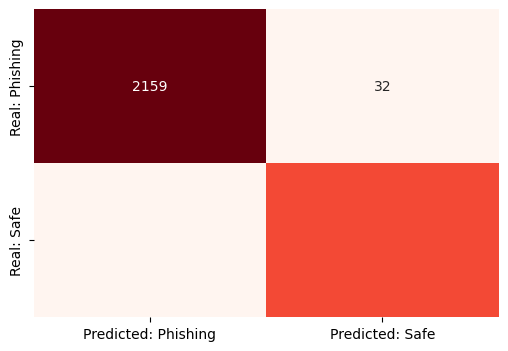

In [66]:
print('Training Accuracy:', lr.score(X_train, y_train))
print('Testing Accuracy:', lr.score(X_test, y_test))
cm = pd.DataFrame(confusion_matrix(lr.predict(X_test), y_test),
                        columns=['Predicted: Phishing', 'Predicted: Safe'],
                        index=['Real: Phishing', 'Real: Safe'])

print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds", cbar=False)
plt.show()

## 2_Naives Bayes model <a id='MultinomialNB_2'></a>

In [67]:
# create the Multinomial Naîves Bayes model
nb = MultinomialNB()

In [68]:
nb.fit(X_train,y_train)

/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MultinomialNB()

In [69]:
nb.score(X_test,y_test)

/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


0.9769099201824402

In [70]:
Scores_ml['MultinomialNB'] = np.round(nb.score(X_test,y_test),2)

/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


Training Accuracy: 0.9904490377761939
Testing Accuracy: 0.9769099201824402

CONFUSION MATRIX


/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


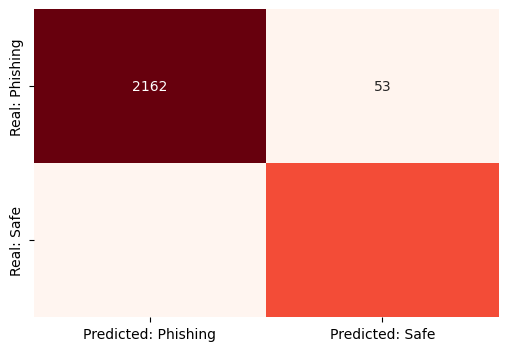

In [71]:
print('Training Accuracy:', nb.score(X_train, y_train))
print('Testing Accuracy:', nb.score(X_test, y_test))
con_mat = pd.DataFrame(confusion_matrix(nb.predict(X_test), y_test),
                        columns=['Predicted: Phishing', 'Predicted: Safe'],
                        index=['Real: Phishing', 'Real: Safe'])

print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap="Reds", cbar=False)
plt.show()

# Loading the scaler and the best model <a id='best_model'></a>

In [72]:
#save of the best model

In [73]:
#save le logistic model
path = "./"
model_file_name = "log_model.pkl"

with open(path + model_file_name, "wb") as file:
    pickle.dump(model_file_name, file)

pickle.dump(lr,open('log_model.pkl','wb'))



In [74]:
import pickle

# Save the vectorizer
with open('count_vectorizer.pkl', 'wb') as file:
    pickle.dump(count_vectorizer, file)

# Load the vectorizer
with open('count_vectorizer.pkl', 'rb') as file:
    count_vectorizer = pickle.load(file)


In [75]:
loaded_model = pickle.load(open('log_model.pkl', 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)


0.9820410490307868


/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/linexploit/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


In [76]:
# Load the model from the file
with open('log_model.pkl', 'rb') as file:
    log_model = pickle.load(file)

In [ ]:
#TEST

In [90]:
def preprocess_email(email):
    # Lowercase the email
    email = email.lower()

    # Remove punctuation
    punctuation_pattern = r'[^\w\s]'
    email = re.sub(punctuation_pattern, '', email)

    # Tokenize the email
    email_tokens = email.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    email_tokens = [token for token in email_tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    email_tokens = [lemmatizer.lemmatize(token) for token in email_tokens]

    # Join the tokens back together
    email = ' '.join(email_tokens)

    return email

# Your email
email = """	Email Text
53	interview schedule for greg mikkelson attached please find the interview packet for the above - referenced person . the interview will happen tuesday , july 11 , 2000 . print all three documents for your hard copies . if you have any questions , or conflicts of schedule , please do not hesitate to contact me . liz alvarado 58983"""

# Preprocess the email
email = preprocess_email(email)

# Fit the CountVectorizer on the training data
# count_vectorizer.fit(X_train)

# Transform the email into a vector of features
email_vectorized = count_vectorizer.transform([email])

# Convert the result to an array
email_array = email_vectorized.toarray()

# Now you can use your model to predict whether the email is a phishing email or not
prediction = log_model.predict(email_array)

if prediction[0] == 1:
    print("The email is a phishing email.")
else:
    print("The email is safe.")


The email is safe.
